### Imports

In [198]:
import pandas as pd
import geopandas as gpd
import numpy as np
import sys
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.cm as cm

In [153]:
print(sys.version)

3.12.2 (tags/v3.12.2:6abddd9, Feb  6 2024, 21:26:36) [MSC v.1937 64 bit (AMD64)]


### __Indicateur 1 :__ Répartition de l'emploi en fonction des secteurs d'activé d'une métropole à une autre 

Cas retenu : Métropole de Bordeaux vs Métropole de Toulouse
> Arguments :
- Proximité géographique
- Population d'une taille similaire
- Densité de population proche
- Taille relativement similaire

#### Chargement des données :

In [154]:
df_bdx = pd.read_excel("data\\raw\\bdd-etablissements-BM-2018-2024-pour comparaison EPCI.xlsx")
df_tls = pd.read_excel("data\\raw\\bdd-etablissements-EPCI-Toulouse-2018-2024.xlsx")

KeyboardInterrupt: 

#### Nettoyage des données 

In [6]:
# conversion des dates
df_bdx['DATE_CREATION_ETAB'] = pd.to_datetime(df_bdx['DATE_CREATION_ETAB'], format='%Y%m%d', errors='coerce')
df_bdx['DATE_FERMETURE_ETAB'] = pd.to_datetime(df_bdx['DATE_FERMETURE_ETAB'], format='%Y%m%d', errors='coerce')
df_tls['DATE_CREATION_ETAB'] = pd.to_datetime(df_tls['DATE_CREATION_ETAB'], format='%Y%m%d', errors='coerce')
df_tls['DATE_FERMETURE_ETAB'] = pd.to_datetime(df_tls['DATE_FERMETURE_ETAB'], format='%Y%m%d', errors='coerce')

# drops les lignes liées aux erreurs d'extraction
df_bdx.dropna(subset=['ETAT_ADMINISTRATIF_ETAB'], inplace=True)
df_tls.dropna(subset=['ETAT_ADMINISTRATIF_ETAB'], inplace=True)

In [7]:
print(df_bdx.shape)
print(df_tls.shape)

(150000, 29)
(150000, 29)


On constate d'ailleurs que les 2 datasets font exactement la même taille, ce qui n'est pas logique. L'extraction semble avoir été limitée pour chaque cas, on travaille donc avec un échantillon des données. Il serait plus intéressant à l'avenir de passer par l'API pour faire du calcul en temps réel sur les statistiques & charts ci dessous.

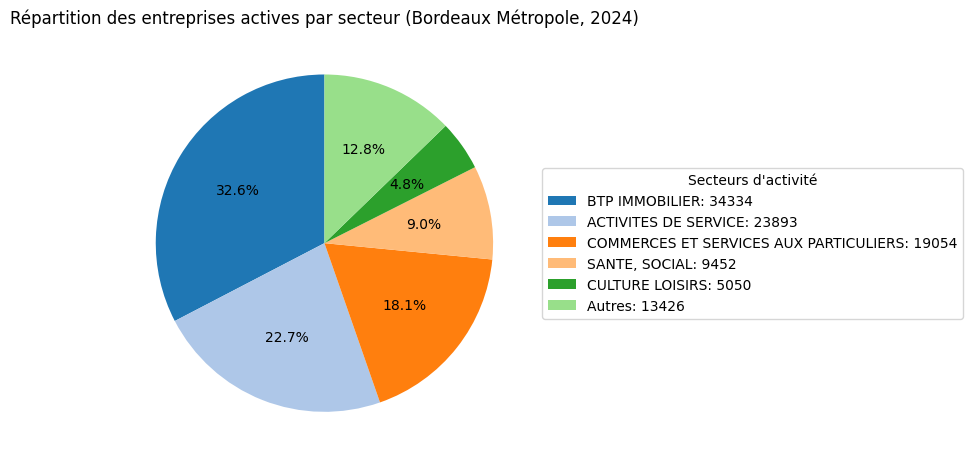

Nombre d'entreprises actives en 2024 à Bordeaux Métropole : 105574 (-2.0%) par rapport à 2023
Nombre d'entreprises créées en 2024 à Bordeaux Métropole : 4279 (-11.1%) par rapport à 2023


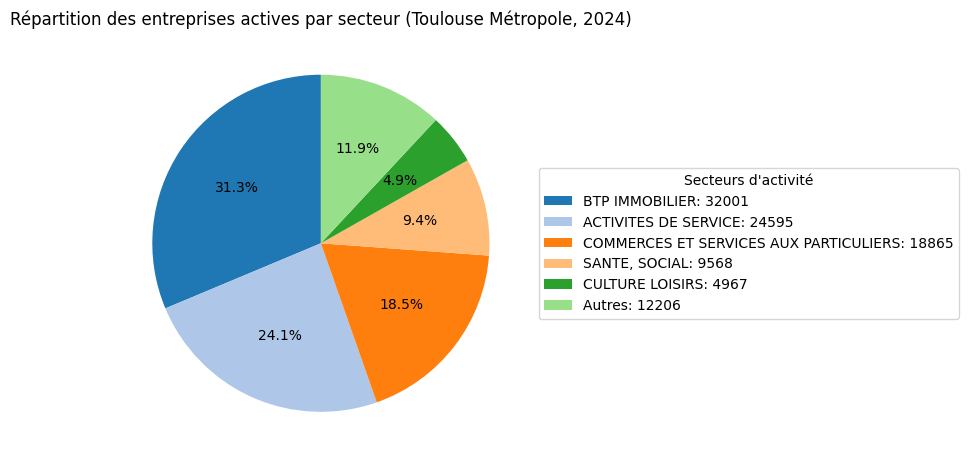

Nombre d'entreprises actives en 2024 à Toulouse Métropole : 102565 (-2.2%) par rapport à 2023
Nombre d'entreprises créées en 2024 à Toulouse Métropole : 4009 (-16.3%) par rapport à 2023


In [40]:
def analyze_sectors(dataframe_principal, nom_ville, annee):
    # Définir les plages de dates pour l'année donnée (N) et l'année précédente (N-1)
    date_debut_annee = f'{annee}-01-01'
    date_fin_annee = f'{annee}-12-31'
    date_debut_annee_precedente = f'{annee - 1}-01-01'
    date_fin_annee_precedente = f'{annee - 1}-12-31'

    # Filtrer les entreprises actives pour l'année N
    entreprises_actives_annee = dataframe_principal[
        (dataframe_principal['DATE_CREATION_ETAB'] <= date_fin_annee) & 
        ((dataframe_principal['DATE_FERMETURE_ETAB'] >= date_debut_annee) |
         (dataframe_principal['DATE_FERMETURE_ETAB'].isnull()))
    ]

    # Filtrer les entreprises actives pour l'année N-1
    entreprises_actives_annee_precedente = dataframe_principal[
        (dataframe_principal['DATE_CREATION_ETAB'] <= date_fin_annee_precedente) & 
        ((dataframe_principal['DATE_FERMETURE_ETAB'] >= date_debut_annee_precedente) |
         (dataframe_principal['DATE_FERMETURE_ETAB'].isnull()))
    ]

    # Filtrer les entreprises créées pendant l'année N
    entreprises_creees_annee = dataframe_principal[
        (dataframe_principal['DATE_CREATION_ETAB'] >= date_debut_annee) & 
        (dataframe_principal['DATE_CREATION_ETAB'] <= date_fin_annee)
    ]

    # Filtrer les entreprises créées pendant l'année N-1
    entreprises_creees_annee_precedente = dataframe_principal[
        (dataframe_principal['DATE_CREATION_ETAB'] >= date_debut_annee_precedente) & 
        (dataframe_principal['DATE_CREATION_ETAB'] <= date_fin_annee_precedente)
    ]

    # Calculer les métriques globales
    nombre_entreprises_actives_annee = entreprises_actives_annee.drop_duplicates(subset='SIRET').shape[0]
    nombre_entreprises_actives_annee_precedente = entreprises_actives_annee_precedente.drop_duplicates(subset='SIRET').shape[0]

    nombre_entreprises_creees_annee = entreprises_creees_annee.drop_duplicates(subset='SIRET').shape[0]
    nombre_entreprises_creees_annee_precedente = entreprises_creees_annee_precedente.drop_duplicates(subset='SIRET').shape[0]

    # Calculer les variations
    variation_entreprises_actives = (
        (nombre_entreprises_actives_annee - nombre_entreprises_actives_annee_precedente) / 
        nombre_entreprises_actives_annee_precedente * 100
        if nombre_entreprises_actives_annee_precedente > 0 else 0
    )

    variation_entreprises_creees = (
        (nombre_entreprises_creees_annee - nombre_entreprises_creees_annee_precedente) / 
        nombre_entreprises_creees_annee_precedente * 100
        if nombre_entreprises_creees_annee_precedente > 0 else 0
    )

    # Calculer la répartition des entreprises actives par secteur
    repartition_par_secteur = entreprises_actives_annee.drop_duplicates(subset='SIRET').groupby(
        'SECTEUR_D_ACTIVITE'
    ).size()

    # Limiter au top 5 et regrouper les autres secteurs
    top_5_secteurs = repartition_par_secteur.nlargest(5)
    autres = repartition_par_secteur.sum() - top_5_secteurs.sum()
    top_5_secteurs['Autres'] = autres

    #   Piechart
    plt.figure(figsize=(8, 6))
    wedges, texts, autotexts = plt.pie(
        top_5_secteurs, 
        autopct='%1.1f%%', 
        startangle=90, 
        colors=plt.cm.tab20.colors[:len(top_5_secteurs)]
    )
    legend_labels = [f"{label}: {value}" for label, value in zip(top_5_secteurs.index, top_5_secteurs.values)]
    plt.legend(wedges, legend_labels, title="Secteurs d'activité", loc="center left", bbox_to_anchor=(1, 0.5))
    plt.title(f"Répartition des entreprises actives par secteur ({nom_ville}, {annee})")
    plt.tight_layout()
    plt.show()

    # Résumé des résultats
    print(f"Nombre d'entreprises actives en {annee} à {nom_ville} : {nombre_entreprises_actives_annee} "
          f"({variation_entreprises_actives:+.1f}%) par rapport à {annee - 1}")
    print(f"Nombre d'entreprises créées en {annee} à {nom_ville} : {nombre_entreprises_creees_annee} "
          f"({variation_entreprises_creees:+.1f}%) par rapport à {annee - 1}")

# Exemple d'appel pour Bordeaux et Toulouse
analyze_sectors(df_bdx, 'Bordeaux Métropole', 2024)
analyze_sectors(df_tls, 'Toulouse Métropole', 2024)


### __Indicateur 2 :__ Evolution des offres d'emploi postées 

Cas retenu : Gironde 2018 vs 2023 (voir l'impact du covid sur certains domaines)
> Arguments :
- Constater les secteurs d'activité les plus dynamiques
- Identifier les secteurs en difficulté
- Voir si les formations proposées par les établissements de la métropole sont en adéquation avec les besoins du marché

In [137]:
df_offres_somme_2023 = pd.read_csv(r'data\raw\data-offre-france-dept-sect-regroupé-2023.csv', sep=';', skiprows=3)
df_offres_somme_2018 = pd.read_csv(r'data\raw\data-offre-france-dept-sect-regroupé-2018.csv', sep=';', skiprows=3)
# on prend pas en compte les lignes descriptives des csv

In [138]:
df_gironde_23 = df_offres_somme_2023[df_offres_somme_2023['Département'] == 'Gironde 33'].copy()
df_gironde_18 = df_offres_somme_2018[df_offres_somme_2018['Département'] == 'Gironde 33'].copy()

df_gironde_23 = df_gironde_23.drop(columns=['Département']).reset_index(drop=True)
df_gironde_18 = df_gironde_18.drop(columns=['Département']).reset_index(drop=True)

# convertir toutes les valeurs type '3 104' en 3104 pour faire une conversion en numérique après
df_gironde_23 = df_gironde_23.apply(lambda x: x.str.replace(' ', '') if x.dtype == 'object' else x)
df_gironde_18 = df_gironde_18.apply(lambda x: x.str.replace(' ', '') if x.dtype == 'object' else x)
df_gironde_23 = df_gironde_23.apply(pd.to_numeric)
df_gironde_18 = df_gironde_18.apply(pd.to_numeric)

# convertir les float en int en suppressionnant les décimales
df_gironde_23 = df_gironde_23.astype(int)
df_gironde_18 = df_gironde_18.astype(int)

print(df_gironde_23.shape)
print(df_gironde_18.shape)

(1, 39)
(1, 39)


In [139]:
# Transposer le dataset
df_transposed_23 = df_gironde_23.T.reset_index()
df_transposed_18 = df_gironde_18.T.reset_index()

# Renommer les colonnes
df_transposed_23.columns = ['Secteur', 'Nbr offres']
df_transposed_18.columns = ['Secteur', 'Nbr offres']

# Supprimer la première ligne si elle contient les labels d'origine
df_transposed_23 = df_transposed_23.iloc[1:].reset_index(drop=True)
df_transposed_18 = df_transposed_18.iloc[1:].reset_index(drop=True)

# Convertir la colonne 'Nbr offres' en type numérique si nécessaire
df_transposed_23['Nbr offres'] = pd.to_numeric(df_transposed_23['Nbr offres'], errors='coerce')
df_transposed_18['Nbr offres'] = pd.to_numeric(df_transposed_18['Nbr offres'], errors='coerce')


In [140]:
# drop les lignes avec 'Secteur' = 'Total' 
df_transposed_23 = df_transposed_23[df_transposed_23['Secteur'] != 'Total']
df_transposed_18 = df_transposed_18[df_transposed_18['Secteur'] != 'Total']

In [141]:
# récupérer les 5 lignes avec la plus grande valeur de 'Nbr offres'
top_5_23 = df_transposed_23.nlargest(5, 'Nbr offres')
top_5_18 = df_transposed_18.nlargest(5, 'Nbr offres')
print(top_5_23)
print(top_5_18)

# joindre les 2 dataframes
df_offres_comparaison = pd.merge(df_transposed_23, df_transposed_18, on='Secteur', how='left', suffixes=('_2023', '_2018'))

                                              Secteur  Nbr offres
28  ACTIVITÉS DE SERVICES ADMINISTRATIFS ET DE SOU...       62670
32  HÉBERGEMENT MÉDICO-SOCIAL ET SOCIAL ET ACTION ...       16980
19                        HÉBERGEMENT ET RESTAURATION       12250
17  COMMERCE- RÉPARATION D'AUTOMOBILES ET DE MOTOC...        9620
25  ACTIVITÉS JURIDIQUES, COMPTABLES, DE GESTION, ...        8470
                                              Secteur  Nbr offres
28  ACTIVITÉS DE SERVICES ADMINISTRATIFS ET DE SOU...       50190
32  HÉBERGEMENT MÉDICO-SOCIAL ET SOCIAL ET ACTION ...       12780
17  COMMERCE- RÉPARATION D'AUTOMOBILES ET DE MOTOC...       11720
19                        HÉBERGEMENT ET RESTAURATION        9930
25  ACTIVITÉS JURIDIQUES, COMPTABLES, DE GESTION, ...        8220


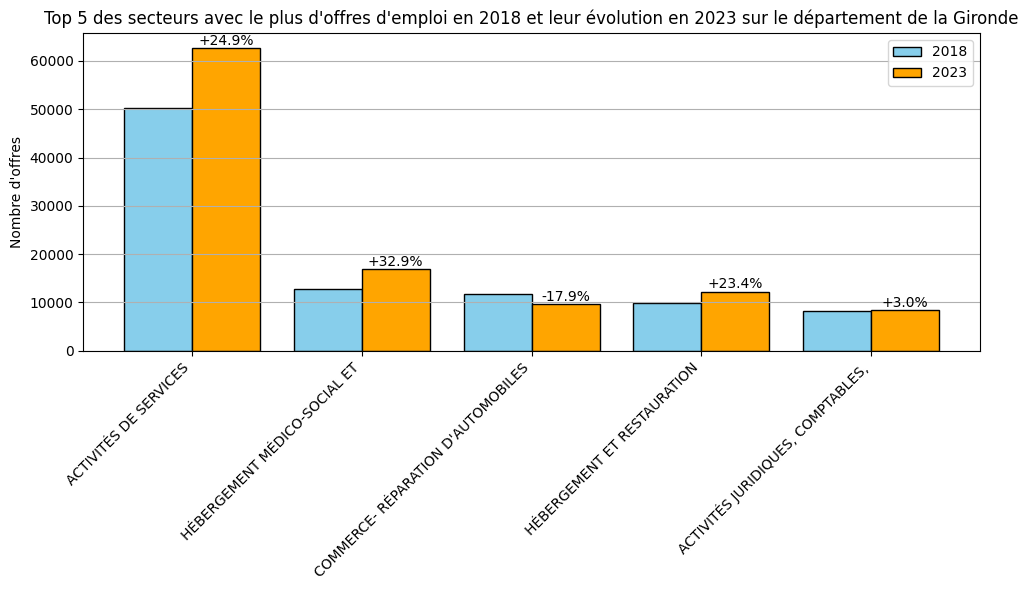

In [149]:
# Sélection du top 5 des secteurs avec le plus d'offres en 2018
df_top_5_2018 = df_offres_comparaison.nlargest(5, 'Nbr offres_2018').copy()

# Calcul de l'évolution en pourcentage entre 2018 et 2023
df_top_5_2018['Évolution (%)'] = (
    (df_top_5_2018['Nbr offres_2023'] - df_top_5_2018['Nbr offres_2018']) / df_top_5_2018['Nbr offres_2018']
) * 100

# Réduction des noms de secteurs à leurs trois premiers mots
df_top_5_2018['Secteur court'] = df_top_5_2018['Secteur'].apply(lambda x: ' '.join(x.split()[:3]))

# Création du graphique
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(df_top_5_2018))  # Positions pour les barres
bar_width = 0.4  # Largeur des barres

# Barres pour 2018
bars_2018 = ax.bar(x - bar_width / 2, df_top_5_2018['Nbr offres_2018'], width=bar_width, label='2018', color='skyblue', edgecolor='black')

# Barres pour 2023
bars_2023 = ax.bar(x + bar_width / 2, df_top_5_2018['Nbr offres_2023'], width=bar_width, label='2023', color='orange', edgecolor='black')

# Ajout des pourcentages au-dessus des barres
for i, (bar_2023, evolution) in enumerate(zip(bars_2023, df_top_5_2018['Évolution (%)'])):
    evolution_text = f"{evolution:+.1f}%"  # Ajouter "+" pour les valeurs positives
    ax.text(
        bar_2023.get_x() + bar_2023.get_width() / 2,  # Position horizontale
        bar_2023.get_height() + 50,  # Position verticale (au-dessus de la barre)
        evolution_text,  # Texte du pourcentage
        ha='center', va='bottom', fontsize=10
    )

# Configuration des labels et du graphique
ax.set_xticks(x)
ax.set_xticklabels(df_top_5_2018['Secteur court'], rotation=45, ha='right')
ax.yaxis.grid(True)
ax.set_ylabel('Nombre d\'offres')
ax.set_title('Top 5 des secteurs avec le plus d\'offres d\'emploi en 2018 et leur évolution en 2023 sur le département de la Gironde')
ax.legend()

plt.tight_layout()
plt.show()


### __Indicateur 3 :__ Répartition des types de contrats (CDI/CDD) par géographiquement

Cas retenu : Gironde
> Arguments :
- montrer que l'hypercentre concentre les contrats
- pouvoir montrer les écarts homme/femme et travailler sur la précarité

In [205]:
df_communes = pd.read_excel('data\\raw\\bdd-Chiffres-Emploi-BM-detail communes-2021.xlsx')

KeyboardInterrupt: 

In [180]:
df_communes.head()
df_communes.dtypes

NOM_SOURCE            object
MILLESIME            float64
NIVEAU_GEO            object
CODEINSEE              int32
COMMUNE               object
CODE_INDICATEUR       object
INDICATEUR            object
VALEUR                 int32
STATUT                object
TYPE_IND             float64
NIVEAU1               object
NIVEAU2               object
NIVEAU3               object
NIVEAU4               object
NIVEAU5               object
NIVEAU6               object
NIVEAU7               object
NIVEAU8               object
NIVEAU9               object
NIVEAU10              object
TYPE_ARBORESCENCE     object
SEXE                  object
TYPE_CONTRAT          object
dtype: object

In [168]:
# Fill non-finite values with 0 before converting to integers
df_communes['VALEUR'] = df_communes['VALEUR'].fillna(0).astype(int)

# créer la colonne 'SEXE' via 'INDICATEUR' si ça commence par 'H -' ou 'HOMMES - ou 'F-' ou 'FEMMES -'
df_communes['SEXE'] = df_communes['INDICATEUR'].apply(lambda x: 'H' if str(x).startswith('H -') or str(x).startswith('HOMMES -') else 'F')

# créer le colonne 'TYPE_CONTRAT' via 'INDICATEUR' si ça contient 'CDD'= 'CDD', 'CDI' ou 'DUREE LIMITEE' = 'CDI', 'APPRENTISSAGE' = 'APPRENTISSAGE', 'INTERIM' = 'INTERIM', 'STAGIAIRES' = 'STAGE', 'CES' = 'CES', 'INDEPENDANTS' = 'INDEPENDANTS', 'EMPLOYEURS' = 'EMPLOYEURS', 'CHOMEURS' = 'CHOMEURS', 'AIDES FAMILIAUX' = 'AIDES FAMILIAUX', '- SALARIES' = 'NON SPECIFIE' else null
df_communes['TYPE_CONTRAT'] = df_communes['INDICATEUR'].apply(
    lambda x: 'CDD' if 'CDD' in str(x) else
    'CDI' if 'CDI' in str(x) or 'DUREE LIMITEE' in str(x) else
    'APPRENTISSAGE' if 'APPRENTISSAGE' in str(x) else
    'INTERIM' if 'INTERIM' in str(x) else
    'STAGE' if 'STAGIAIRES' in str(x) else
    'CES' if 'CES' in str(x) else
    'INDEPENDANTS' if 'INDEPENDANTS' in str(x) else
    'EMPLOYEURS' if 'EMPLOYEURS' in str(x) else
    'CHOMEURS' if 'CHOMEURS' in str(x) else
    'AIDES FAMILIAUX' if 'AIDES FAMILIAUX' in str(x) else
    'NON SPECIFIE' if '- SALARIES' in str(x) else
    None
)

# SUPPRIMER LES LIGNES AVEC ['TYPE_CONTRAT'] = None
df_communes = df_communes.dropna(subset=['TYPE_CONTRAT'])
df_communes['CODEINSEE'] = df_communes['CODEINSEE'].astype(int)

In [183]:
# Charger le fichier GeoJSON
gdf_geo = gpd.read_file("data\\raw\\communes.geojson")

# Vérifier les colonnes disponibles
print(gdf_geo.head())

    code                       nom  \
0  33200                   Haillan   
1  33332                 Porchères   
2  33453  Saint-Michel-de-Lapujade   
3  33467  Saint-Quentin-de-Caplong   
4  33138                   Coutras   

                                            geometry  
0  POLYGON ((-0.68068 44.89482, -0.66925 44.89547...  
1  POLYGON ((-0.00541 45.05461, 0.00627 45.05611,...  
2  POLYGON ((0.04245 44.5815, 0.06071 44.58434, 0...  
3  POLYGON ((0.12917 44.77842, 0.12003 44.78269, ...  
4  POLYGON ((-0.15905 45.03435, -0.17447 45.04226...  


In [184]:
# Convertir les deux colonnes en type string si nécessaire
gdf_geo['code'] = gdf_geo['code'].astype(str)
df_communes['CODEINSEE'] = df_communes['CODEINSEE'].astype(str)

# Faire la jointure sur la colonne correspondante
gdf_merged = gdf_geo.merge(df_communes, left_on='code', right_on='CODEINSEE', how='inner')

# Vérifier le résultat
print(gdf_merged.head())

    code      nom                                           geometry  \
0  33200  Haillan  POLYGON ((-0.68068 44.89482, -0.66925 44.89547...   
1  33200  Haillan  POLYGON ((-0.68068 44.89482, -0.66925 44.89547...   
2  33200  Haillan  POLYGON ((-0.68068 44.89482, -0.66925 44.89547...   
3  33200  Haillan  POLYGON ((-0.68068 44.89482, -0.66925 44.89547...   
4  33200  Haillan  POLYGON ((-0.68068 44.89482, -0.66925 44.89547...   

                            NOM_SOURCE  MILLESIME NIVEAU_GEO CODEINSEE  \
0  RP RENOVE CHIFFRES DETAILLES EMPLOI     2021.0        COM     33200   
1  RP RENOVE CHIFFRES DETAILLES EMPLOI     2021.0        COM     33200   
2  RP RENOVE CHIFFRES DETAILLES EMPLOI     2021.0        COM     33200   
3  RP RENOVE CHIFFRES DETAILLES EMPLOI     2021.0        COM     33200   
4  RP RENOVE CHIFFRES DETAILLES EMPLOI     2021.0        COM     33200   

      COMMUNE CODE_INDICATEUR  \
0  Le Haillan        RPA6F52C   
1  Le Haillan        RPA6F52P   
2  Le Haillan        RP

In [191]:
# Filtrer les CDI et sommer les valeurs
type_contrat = 'CDI'

df_type = df_communes[df_communes['TYPE_CONTRAT'] == type_contrat]
top_type = df_type.groupby(['CODEINSEE', 'COMMUNE'], as_index=False)['VALEUR'].sum()

# Trier et garder les 5 premières communes
top_type = top_type.sort_values(by='VALEUR', ascending=False).head(5)

# Joindre avec le GeoDataFrame
gdf_top_type = gdf_geo.merge(top_type, left_on='code', right_on='CODEINSEE', how='inner')


C:\Users\emman\AppData\Local\Temp\ipykernel_40944\953169462.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('autumn', len(gdf_top_type_sorted))  # Normalisation automatique


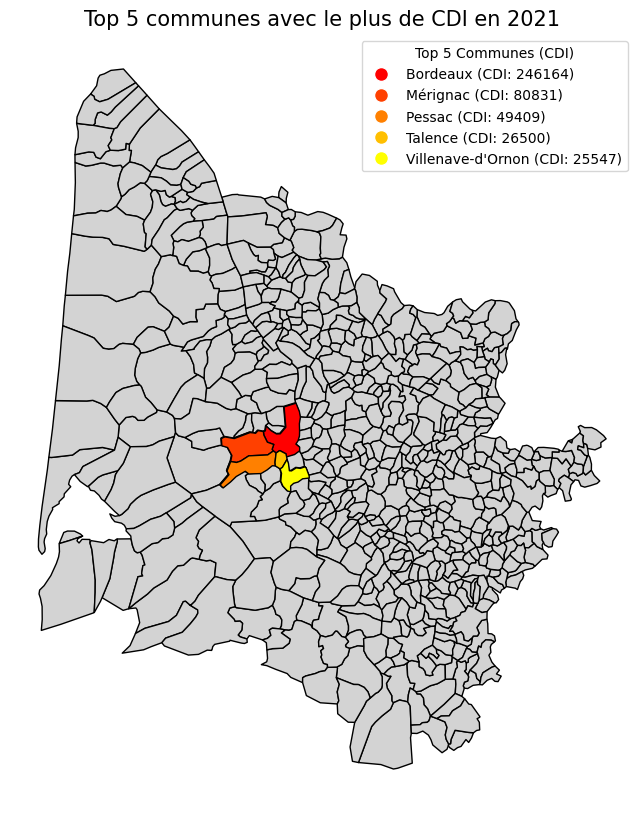

In [ ]:
type_contrat = 'CDI'  # Variable pour le type de contrat

fig, ax = plt.subplots(figsize=(10, 10))

# Afficher toutes les communes en gris
gdf_geo.plot(ax=ax, color='lightgrey', edgecolor='black')

# Trier les données dans l'ordre décroissant pour la légende
gdf_top_type_sorted = gdf_top_type.sort_values(by='VALEUR', ascending=False)

# Générer une palette de couleurs distinctes à partir de la colormap
cmap = cm.get_cmap('autumn', len(gdf_top_type_sorted))  # Normalisation automatique
colors = [cmap(i) for i in range(len(gdf_top_type_sorted))]

# Ajouter chaque commune avec une couleur différente
legend_elements = []
for i, (_, row) in enumerate(gdf_top_type_sorted.iterrows()):
    # Dynamiser le texte en fonction de type_contrat
    commune_label = f"{row['COMMUNE']} ({type_contrat}: {row['VALEUR']})"
    # Couleur pour cette commune
    color = colors[i]
    # Ajouter un élément pour la légende
    legend_elements.append(Line2D([0], [0], marker='o', color='w', label=commune_label,
                                   markerfacecolor=color, markersize=10))
    # Tracer cette commune avec sa couleur
    gdf_top_type_sorted.iloc[[i]].plot(ax=ax, color=color, edgecolor='black')

# Ajouter la légende en haut à droite
ax.legend(handles=legend_elements, loc='upper right', title=f"Top 5 Communes ({type_contrat})", fontsize=10)

# Configurer le titre avec type_contrat
ax.set_title(f"Top 5 communes avec le plus de {type_contrat} en 2021", fontsize=15)
ax.axis('off')

# Afficher la carte
plt.show()


### __Indicateur 4 :__ Répartition des types de contrat par secteur 

Cas retenu : Métropole de Bordeaux
> Arguments :
- Voir les secteurs les plus précaires
- Constater une potentielle disparité homme femme.

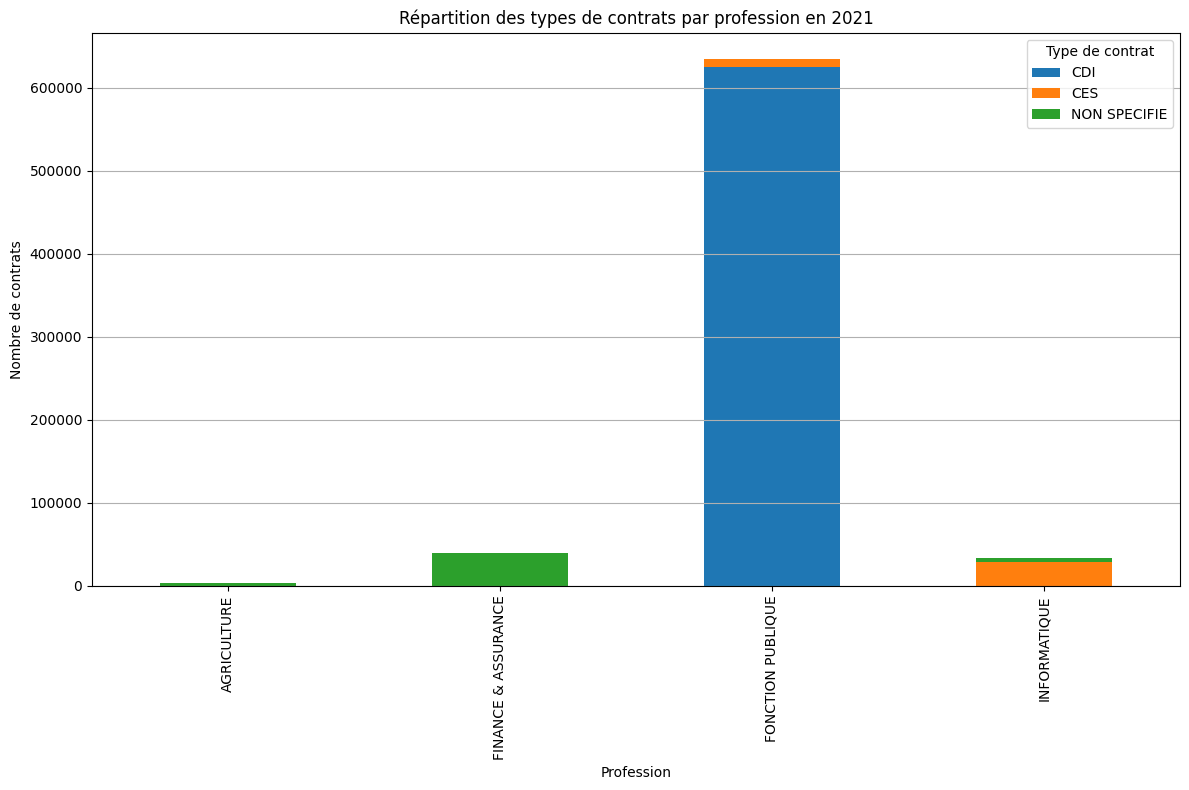

In [ ]:
df_communes.head()

# créer la colonne 'PROFESSION' via 'INDICATEUR' si ça contient 'INFORMATIQUES' = 'INFORMATIQUE', 'AGRICULTURE' = 'AGRICULTURE', 'FONCTION PUB' = 'FONCTION PUBLIQUE'?
# 'FINANCIERES' = 'FINANCE & ASSURANCE', 'ENERG' = 'ENERGIE'

df_communes['PROFESSION'] = df_communes['INDICATEUR'].apply(
    lambda x: 'INFORMATIQUE' if 'INFORMATIQUES' in str(x) else
    'AGRICULTURE' if 'AGRICULTURE' in str(x) else
    'FONCTION PUBLIQUE' if 'FONCTION PUB' in str(x) else
    'FINANCE & ASSURANCE' if 'FINANCIERES' in str(x) else
    'ENERGIE' if 'ENERG' in str(x) else
    None
)

# SUPPRIMER LES LIGNES AVEC ['PROFESSION'] = None
# df_communes = df_communes.dropna(subset=['PROFESSION'])

# PLot les [TYPE_CONTRAT] réparties par [PROFESSION]
fig, ax = plt.subplots(figsize=(12, 8))

# Créer un graphique en barres empilées
df_grouped = df_communes.groupby(['PROFESSION', 'TYPE_CONTRAT'], as_index=False)['VALEUR'].sum()
df_pivot = df_grouped.pivot(index='PROFESSION', columns='TYPE_CONTRAT', values='VALEUR')
df_pivot.plot(kind='bar', stacked=True, ax=ax)

# Configurer le graphique
ax.set_title('Répartition des types de contrats par profession en 2021')
ax.set_ylabel('Nombre de contrats')
ax.set_xlabel('Profession')
ax.yaxis.grid(True)
ax.legend(title='Type de contrat')

plt.tight_layout()
plt.show()

# revoir les labels contrat et professions proprement